# Creating Normalised Training Data

In this notebook we will be doing the following :
  1. Build & perform basic text cleaning operations/pipeline on the documents
  2. Convert the data in training data format. i.e. _label_tag1 _label_tag2
  3. Split the dataset into : train,dev and test sets  
  4.  Divide the dataset into Groups/Classes  
    a. Dividing the entire Dataset(~1M) into 14 groups/class.  
    b. Check the Label Distribution of Labels in each 14 groups/class.      
    c. **Set Threshold to clip the maximum number of examples of a Label in a group/class.**  
  5. Create Corpus & Label Dictionary : Flair Corpus
  6. Visualise Tag Distribution

**HOT TIP** : *Save them as pickle for easy rendering for experiments*



In [1]:
# First let's check what has Google given us ! Thank you Google for the GPU
!nvidia-smi

Thu Jan  9 14:04:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [8]:
# Let's mount our G-Drive. Hey !! Because for GPU you now give your data to Google 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install necessary packages and restart the environment

! pip install tiny-tokenizer
! pip install  flair

  Created wheel for tiny-tokenizer: filename=tiny_tokenizer-3.1.0-cp36-none-any.whl size=10550 sha256=1e84e6333271e9a45bc81201cdccc9e83ab372232176869f9c01945e292cbb57
  Stored in directory: /root/.cache/pip/wheels/d1/c8/36/334497a689fab90128232e86b5829b800dd271a3d5d5959c53
Successfully built tiny-tokenizer
     |████████████████████████████████| 194kB 2.7MB/s 
     |████████████████████████████████| 798kB 50.2MB/s 
     |████████████████████████████████| 450kB 43.3MB/s 
     |████████████████████████████████| 778kB 46.6MB/s 
     |████████████████████████████████| 1.0MB 34.2MB/s 
     |████████████████████████████████| 1.0MB 28.4MB/s 
     |████████████████████████████████| 3.8MB 38.2MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
     |████████████████████████████████| 70.7MB 41kB/s 
     |████████████████████████████████| 21.5MB 36.8MB/s 
     |████████████████████████████████| 870kB 25.2MB/s 
     |████████████████████████████████| 348kB 48.5MB/s 
  Created wheel for mp

In [1]:
# Let's import our packages !

import pandas as pd
from tqdm import tqdm
import html
import re
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
# import flair
import pickle
from torch.optim.adam import Adam
import json

# Making Corpus

from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.samplers import ImbalancedClassificationDatasetSampler

import matplotlib.pyplot as plt 
%matplotlib inline

In [0]:
## Mentioning where is our data located on G-Drive. Make sure to rectify your path

path = '/content/drive/My Drive/ICDMAI_Tutorial/notebook/'
tag_group = '/content/drive/My Drive/ICDMAI_Tutorial/stack-overflow-tag-network/stack_network_nodes.csv'
data ='filtered_data/question_tag_text_mapping.pkl'

In [3]:
# Let's see the main Data-Set

question_tag = pd.read_pickle(path+data)
question_tag.head()

Id  ...                   Tag
0  120  ...        [sql, asp.net]
1  260  ...            [c#, .net]
2  330  ...                 [c++]
3  470  ...  [web-services, .net]
4  580  ...          [sql-server]

[5 rows x 8 columns]

In [4]:
# Let's see the Groups/Classes

tag_group = pd.read_csv(tag_group)
tag_group.head()

name  group  nodesize   group_name
0       c      1    189.83  Programming
1     c++      1    268.11  Programming
2  django      1     40.91  Programming
3  python      1    438.67  Programming
4   flask      1      9.39  Programming

## 1. Text Pre-processing Pipeline

Every try-except block can be written as a different modular function which can be invoked from preprocess_text() function. This serves as a pipeline of the series of text-cleaning that you might require for your dataset.

In [0]:
clean = re.compile('<.*?>')

def preprocess_text(text) :
  try :
    # soup = BeautifulSoup(text, "html.parser")
    # text = soup.get_text()
    text=  re.sub(clean, '', text)
    text = html.unescape(text)
  except :
    print("Error in HTML Processing ...")
    print(text)
    text = text
  try :
    # remove extra newlines (often might be present in really noisy text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
  except :
    print("Error in removing extra lines ...")
    print(text)
    text = text

  try :
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    text = text.strip()
  except :
    print("Error in extra whitespace removal ...")
    print(text)
    text = text

  return text

## 2. Create Training Data Format

Here we iterate the dataset dataframe and create the format acceptable to Flair. This is a standard format for few other Text Classification models/frameworks by Facebook.

***Format***  : ____label ____**tag1** ____label ____**tag2** **text**

Here the text Document has to be in a single line which was handled in the preprocess_text() method.


In [0]:
def create_training_format(question_tag) :

  print("Preparing training data format ...")
  # training_df = pd.DataFrame("columns")
  labels = list()
  texts = list()
  for index in tqdm(question_tag.index) :
    tags = question_tag.loc[index,'Tag']
    text_label = ''
    for tag in tags :
      label = '__label__'+tag
      text_label = text_label + ' ' + label
    
    text_label = text_label.strip()
    # text =  html.unescape(question_tag.loc[index,'Body'])
    text =  question_tag.loc[index,'Title'].strip() + '. ' + question_tag.loc[index,'Body'].strip()

    # if len(text.split()) < 5 :
    #   continue 

    labels.append(text_label)
    texts.append(text)


  df = pd.DataFrame(list(zip(labels[:], texts[:])), columns =['label', 'text']) 
  # df.head()
  print("Cleaning Text ....")
  df['text'] = df['text'].apply(preprocess_text)
  print("Cleaned Data Size : {}".format(df.shape))

  return df

## 3. Create Training Splits

Here we create standard random splits of the dataset to :
  1. training set : 70 % data
  2. dev/validation set :  15 % data
  3. test set : 15 % data

#### TO DO : Experiments :
  1. Stratified Sampling
  2. Does a  70-15-15 split or 90-5-5 split make any difference when you ahve 1M records ?

In [0]:
def create_splits(df,path,group_id = ''):

  print("Splitting Training Data ... ")
  df = df.sample(frac=1)
  train_df , test_df = train_test_split(df,random_state=42,test_size=0.20)
  dev_df ,test_df = train_test_split(test_df,random_state=42,test_size=0.5)
  print("Training Dataset : {}".format(train_df.shape[0]))
  print("Validation Dataset : {}".format(dev_df.shape[0]))
  print("Test Dataset : {}".format(test_df.shape[0]))

  print("Path  : {} ".format(path+'training_data/normalised/group/'+ str(group_id) + '/train.txt'))
  train_df.to_csv(path+'training_data/normalised/group/'+ str(group_id) + '/train.txt',sep='\t',index=False,header=False)
  dev_df.to_csv(path+'training_data/normalised/group/'+ str(group_id) + '/dev.txt',sep='\t',index=False,header=False)
  test_df.to_csv(path+'training_data/normalised/group/'+ str(group_id) + '/test.txt',sep='\t',index=False,header=False)

  return train_df,dev_df,test_df

## 4. Divide the dataset into Groups/Classes

Here we iterate over the entire dataset to create group level datasets in the following steps :
  1. Iterate over the groups and read the full-dataset eveytime
  2. Get all the tags in the group from the **tag_group** lookup
  3. Iterate over training examples and see if the labels fall in the same group
  4. Remove training examples which don't belong to the group
  5. Se document with multiple labels and just one label
  6. We keep all the documents with more than one label to keep diversity
  7. With documents with 1 label will, balance the dataset by cliping the number of examples for the label
  8. Finally merge both the dataset.
  9. Create the training data format of the remaining dataset
  10. Split & Save the dataset




In [10]:
for grp_id in range(1,15):
  
  ## 1. Iterate over the groups and read the full-dataset eveytime
  print("=================================================================")
  print("Group ID being Processed : {}".format(grp_id))
  print("=================================================================")
  print("Reading Pickle File ...")
  question_tag = pd.read_pickle(path+data)

  ## 2. Get all the tags in the group from the **tag_group** lookup  

  group =  tag_group[tag_group.group == grp_id]
  labels = list(set(group['name']))

  ## 3. Iterate over training examples and see if the labels fall in the same group
  for index in tqdm(question_tag.index):
    tags = question_tag.loc[index,'Tag']
    group_tags = list()
    for tag in tags :
      if tag in labels :
        group_tags.append(tag)
    question_tag.at[index,'Tag'] =  group_tags

  print("Before Removal of Blank Data : {} ".format(question_tag.shape))

  ## 4. Remove training examples which don't belong to the group
  question_tag = question_tag[question_tag['Tag'].map(lambda d: len(d)) > 0]
  print("Final Data for Group ID  : {} is {}".format(grp_id,question_tag.shape))

  # Segregating Single & Multiple Labels

  question_tag['tag_count'] = question_tag['Tag'].apply(len)
  question_tag = question_tag.sort_values(by = ['tag_count'],ascending=False)

  print("Training Data Size : {}".format(question_tag.shape[0]))
  
  ## 5. Remove document with multiple labels and just one label
  multi_tags = question_tag[question_tag.tag_count >  1]
  single_tags = question_tag[question_tag.tag_count ==  1]

  ## 6. We keep all the documents with more than one label to keep diversity
  print("Size of Multi-Tag Documents :: {}".format(multi_tags.shape[0]))
  
  
  ## 7. With documents with 1 label will, balance the dataset by cliping the number of examples for the label
  # Adding Single tag outside list
  single_tags['open_tag'] = ''
  for index in single_tags.index :
    single_tags.at[index,'open_tag'] = single_tags.loc[index,'Tag'][0
                                                                    ]
  single_tag_grp = single_tags.groupby(['open_tag'],as_index=False).agg({'tag_count' :  'count'}).sort_values(by=['tag_count'],ascending=False)
  print("Decide On Cutt of for Single Threshold ...")
  print(single_tag_grp)

  # Clipping the number of examples via-user input
  threshold = int(input())

  final_df = pd.DataFrame()

  for open_tag in list(single_tag_grp['open_tag'] ) :
    open_tag_df = single_tags[single_tags.open_tag == open_tag].sample(frac=1).reset_index(drop=True).head(threshold)
    final_df = final_df.append(open_tag_df,ignore_index=False)

  print("Verify")
  print(final_df.groupby(['open_tag'],as_index=False).agg({'tag_count' :  'count'}).sort_values(by=['tag_count'],ascending=False))

  multi_tags.pop('tag_count')
  final_df.pop('tag_count')
  final_df.pop('open_tag')

  ## 8. Finally merge both the dataset.
  multi_tags= multi_tags.append(final_df,ignore_index=True)
  print("Training Data Size : {}".format(multi_tags.shape[0]))

  ## 9. Create the training data format of the remaining dataset
  training_data_format = create_training_format(multi_tags)

  ## 10. Split & Save the dataset
  train_df,dev_df,test_df = create_splits(training_data_format,path,group_id=grp_id)
  
  print("=================================================================")


Group ID being Processed : 1
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:43<00:00, 24066.01it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 1 is (163030, 8)
Training Data Size : 163030
Size of Multi-Tag Documents :: 15824


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
           open_tag  tag_count
7            python      55314
1               c++      41047
0                 c      19528
9                 r      15298
2            django       6475
6            matlab       5967
8                qt       2308
5  machine-learning        726
3          embedded        308
4             flask        235
6500


  6%|▌         | 3203/57843 [00:00<00:01, 32025.91it/s]

Verify
           open_tag  tag_count
0                 c       6500
1               c++       6500
7            python       6500
9                 r       6500
2            django       6475
6            matlab       5967
8                qt       2308
5  machine-learning        726
3          embedded        308
4             flask        235
Training Data Size : 57843
Preparing training data format ...


100%|██████████| 57843/57843 [00:01<00:00, 33637.37it/s]


Cleaning Text ....
Cleaned Data Size : (57843, 2)
Splitting Training Data ... 
Training Dataset : 46274
Validation Dataset : 5784
Test Dataset : 5785
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/1/train.txt 
Group ID being Processed : 2
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:41<00:00, 25136.81it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 2 is (196254, 8)
Training Data Size : 196254
Size of Multi-Tag Documents :: 66035


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
            open_tag  tag_count
4                 c#      55193
9                sql      21771
1            asp.net      12962
10        sql-server       7408
0               .net       6019
12            vb.net       5799
15               wpf       4623
13     visual-studio       3273
7             oracle       3177
3              azure       2431
14               wcf       1899
5   entity-framework       1706
11           unity3d       1085
16           xamarin       1051
2    asp.net-web-api        804
6               linq        763
8              plsql        255
6100


  0%|          | 0/123320 [00:00<?, ?it/s]

Verify
            open_tag  tag_count
4                 c#       6100
1            asp.net       6100
9                sql       6100
10        sql-server       6100
0               .net       6019
12            vb.net       5799
15               wpf       4623
13     visual-studio       3273
7             oracle       3177
3              azure       2431
14               wcf       1899
5   entity-framework       1706
11           unity3d       1085
16           xamarin       1051
2    asp.net-web-api        804
6               linq        763
8              plsql        255
Training Data Size : 123320
Preparing training data format ...


100%|██████████| 123320/123320 [00:03<00:00, 33367.60it/s]


Cleaning Text ....
Cleaned Data Size : (123320, 2)
Splitting Training Data ... 
Training Dataset : 98656
Validation Dataset : 12332
Test Dataset : 12332
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/2/train.txt 
Group ID being Processed : 3
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:43<00:00, 24308.28it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 3 is (65453, 8)
Training Data Size : 65453
Size of Multi-Tag Documents :: 13821


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
         open_tag  tag_count
10  ruby-on-rails      16861
3         node.js      10362
9            ruby       8673
4      postgresql       5164
2         mongodb       5042
0   elasticsearch       1947
6         reactjs       1909
7           redis        735
5    react-native        569
1         express        292
8           redux         78
5200


  7%|▋         | 3184/45157 [00:00<00:01, 31835.78it/s]

Verify
         open_tag  tag_count
3         node.js       5200
9            ruby       5200
10  ruby-on-rails       5200
4      postgresql       5164
2         mongodb       5042
0   elasticsearch       1947
6         reactjs       1909
7           redis        735
5    react-native        569
1         express        292
8           redux         78
Training Data Size : 45157
Preparing training data format ...


100%|██████████| 45157/45157 [00:01<00:00, 31895.23it/s]


Cleaning Text ....
Cleaned Data Size : (45157, 2)
Splitting Training Data ... 
Training Dataset : 36125
Validation Dataset : 4516
Test Dataset : 4516
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/3/train.txt 
Group ID being Processed : 4
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:44<00:00, 23860.17it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 4 is (169599, 8)
Training Data Size : 169599
Size of Multi-Tag Documents :: 40863


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
         open_tag  tag_count
0         android      86670
2             ios      16580
3          iphone       7553
4     objective-c       6340
5             osx       5316
6           swift       3556
7           xcode       2139
1  android-studio        582
7500


  4%|▍         | 3205/81296 [00:00<00:02, 32041.47it/s]

Verify
         open_tag  tag_count
0         android       7500
2             ios       7500
3          iphone       7500
4     objective-c       6340
5             osx       5316
6           swift       3556
7           xcode       2139
1  android-studio        582
Training Data Size : 81296
Preparing training data format ...


100%|██████████| 81296/81296 [00:02<00:00, 32021.71it/s]


Cleaning Text ....
Cleaned Data Size : (81296, 2)
Splitting Training Data ... 
Training Dataset : 65036
Validation Dataset : 8130
Test Dataset : 8130
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/4/train.txt 
Group ID being Processed : 5
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:43<00:00, 24178.50it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 5 is (54356, 8)
Training Data Size : 54356
Size of Multi-Tag Documents :: 8845


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
      open_tag  tag_count
10     windows       9116
4        linux       9034
0       apache       6039
2          git       5841
1         bash       3849
6   powershell       3567
8       ubuntu       2017
5        nginx       1850
7        shell       1840
9         unix       1536
3       github        822
6100


  7%|▋         | 3312/48406 [00:00<00:01, 33112.06it/s]

Verify
      open_tag  tag_count
4        linux       6100
10     windows       6100
0       apache       6039
2          git       5841
1         bash       3849
6   powershell       3567
8       ubuntu       2017
5        nginx       1850
7        shell       1840
9         unix       1536
3       github        822
Training Data Size : 48406
Preparing training data format ...


100%|██████████| 48406/48406 [00:01<00:00, 33172.06it/s]


Cleaning Text ....
Cleaned Data Size : (48406, 2)
Splitting Training Data ... 
Training Dataset : 38724
Validation Dataset : 4841
Test Dataset : 4841
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/5/train.txt 
Group ID being Processed : 6
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:43<00:00, 24321.20it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 6 is (356875, 8)
Training Data Size : 356875
Size of Multi-Tag Documents :: 144645


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
               open_tag  tag_count
15                  php      53120
8            javascript      51009
13                mysql      23942
9                jquery      21591
21                  xml      11871
10                 json       9188
3                   css       8911
1             angularjs       8892
5                  html       8783
20            wordpress       3711
0                  ajax       2416
6                 html5       2396
11              laravel       1435
17    twitter-bootstrap       1159
4                drupal       1103
2           codeigniter        992
7       ionic-framework        585
16                 sass        455
18  twitter-bootstrap-3        291
12                 less        165
14            photoshop        139
19               vue.js         76
9200
Verify
               open_tag  tag_count
21                  xml       9200
15                  php       9200
13                mysql       9200


  1%|          | 2788/241342 [00:00<00:08, 27876.77it/s]

Training Data Size : 241342
Preparing training data format ...


100%|██████████| 241342/241342 [00:07<00:00, 33248.47it/s]


Cleaning Text ....
Cleaned Data Size : (241342, 2)
Splitting Training Data ... 
Training Dataset : 193073
Validation Dataset : 24134
Test Dataset : 24135
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/6/train.txt 
Group ID being Processed : 7
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:43<00:00, 24306.98it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 7 is (3460, 8)
Training Data Size : 3460


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Size of Multi-Tag Documents :: 562
Decide On Cutt of for Single Threshold ...
     open_tag  tag_count
0    angular2       1697
1  typescript       1201
1700


100%|██████████| 3460/3460 [00:00<00:00, 29947.81it/s]

Verify
     open_tag  tag_count
0    angular2       1697
1  typescript       1201
Training Data Size : 3460
Preparing training data format ...
Cleaning Text ....


Cleaned Data Size : (3460, 2)
Splitting Training Data ... 
Training Dataset : 2768
Validation Dataset : 346
Test Dataset : 346
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/7/train.txt 
Group ID being Processed : 8
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:42<00:00, 25022.95it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 8 is (143543, 8)
Training Data Size : 143543
Size of Multi-Tag Documents :: 23639


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
        open_tag  tag_count
3           java      95277
1        eclipse       4931
0            api       4005
11  web-services       3579
7           rest       2833
8         spring       2243
6          maven       1881
5            jsp       1755
2      hibernate       1626
4        java-ee        806
10    spring-mvc        627
9    spring-boot        341
5000


  6%|▌         | 3312/53266 [00:00<00:01, 33117.03it/s]

Verify
        open_tag  tag_count
3           java       5000
1        eclipse       4931
0            api       4005
11  web-services       3579
7           rest       2833
8         spring       2243
6          maven       1881
5            jsp       1755
2      hibernate       1626
4        java-ee        806
10    spring-mvc        627
9    spring-boot        341
Training Data Size : 53266
Preparing training data format ...


100%|██████████| 53266/53266 [00:01<00:00, 33884.50it/s]


Cleaning Text ....
Cleaned Data Size : (53266, 2)
Splitting Training Data ... 
Training Dataset : 42612
Validation Dataset : 5327
Test Dataset : 5327
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/8/train.txt 
Group ID being Processed : 9
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:41<00:00, 25560.42it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 9 is (8850, 8)
Training Data Size : 8850


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Size of Multi-Tag Documents :: 148
Decide On Cutt of for Single Threshold ...
              open_tag  tag_count
0  amazon-web-services       3106
4                   go       1843
5              jenkins       1790
3               docker       1530
1                cloud        389
2               devops         44
1900


 43%|████▎     | 3270/7644 [00:00<00:00, 32699.56it/s]

Verify
              open_tag  tag_count
0  amazon-web-services       1900
4                   go       1843
5              jenkins       1790
3               docker       1530
1                cloud        389
2               devops         44
Training Data Size : 7644
Preparing training data format ...


100%|██████████| 7644/7644 [00:00<00:00, 32711.90it/s]


Cleaning Text ....
Cleaned Data Size : (7644, 2)
Splitting Training Data ... 
Training Dataset : 6115
Validation Dataset : 764
Test Dataset : 765
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/9/train.txt 
Group ID being Processed : 10
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:41<00:00, 25553.50it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 10 is (12979, 8)
Training Data Size : 12979
Size of Multi-Tag Documents :: 773


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
       open_tag  tag_count
3         scala       5065
2       haskell       3026
1        hadoop       2875
0  apache-spark       1240
3100


 32%|███▏      | 3480/11014 [00:00<00:00, 34795.72it/s]

Verify
       open_tag  tag_count
3         scala       3100
2       haskell       3026
1        hadoop       2875
0  apache-spark       1240
Training Data Size : 11014
Preparing training data format ...


100%|██████████| 11014/11014 [00:00<00:00, 35013.52it/s]


Cleaning Text ....
Cleaned Data Size : (11014, 2)
Splitting Training Data ... 
Training Dataset : 8811
Validation Dataset : 1101
Test Dataset : 1102
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/10/train.txt 
Group ID being Processed : 11
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:40<00:00, 25837.89it/s]


Before Removal of Blank Data : (1051992, 8) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Final Data for Group ID  : 11 is (5703, 8)
Training Data Size : 5703
Size of Multi-Tag Documents :: 141
Decide On Cutt of for Single Threshold ...
   open_tag  tag_count
0  selenium       3232
1   testing       2330
3300


100%|██████████| 5703/5703 [00:00<00:00, 35614.12it/s]

Verify
   open_tag  tag_count
0  selenium       3232
1   testing       2330
Training Data Size : 5703
Preparing training data format ...
Cleaning Text ....


Cleaned Data Size : (5703, 2)
Splitting Training Data ... 
Training Dataset : 4562
Validation Dataset : 570
Test Dataset : 571
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/11/train.txt 
Group ID being Processed : 12
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:41<00:00, 25541.13it/s]


Before Removal of Blank Data : (1051992, 8) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Final Data for Group ID  : 12 is (570, 8)
Training Data Size : 570
Size of Multi-Tag Documents :: 4
Decide On Cutt of for Single Threshold ...
  open_tag  tag_count
1      tdd        443
0    agile        123
300


100%|██████████| 427/427 [00:00<00:00, 29978.87it/s]

Verify
  open_tag  tag_count
1      tdd        300
0    agile        123
Training Data Size : 427
Preparing training data format ...
Cleaning Text ....
Cleaned Data Size : (427, 2)
Splitting Training Data ... 
Training Dataset : 341
Validation Dataset : 43
Test Dataset : 43
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/12/train.txt 


Group ID being Processed : 13
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:41<00:00, 25225.14it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 13 is (19933, 8)
Training Data Size : 19933
Size of Multi-Tag Documents :: 622


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Decide On Cutt of for Single Threshold ...
  open_tag  tag_count
1    regex      14727
0     perl       4584
4500


 38%|███▊      | 3609/9622 [00:00<00:00, 36086.94it/s]

Verify
  open_tag  tag_count
0     perl       4500
1    regex       4500
Training Data Size : 9622
Preparing training data format ...


100%|██████████| 9622/9622 [00:00<00:00, 35192.93it/s]


Cleaning Text ....
Cleaned Data Size : (9622, 2)
Splitting Training Data ... 
Training Dataset : 7697
Validation Dataset : 962
Test Dataset : 963
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/13/train.txt 
Group ID being Processed : 14
Reading Pickle File ...


100%|██████████| 1051992/1051992 [00:41<00:00, 25257.46it/s]


Before Removal of Blank Data : (1051992, 8) 
Final Data for Group ID  : 14 is (14291, 8)
Training Data Size : 14291
Size of Multi-Tag Documents :: 5684
Decide On Cutt of for Single Threshold ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


    open_tag  tag_count
0      excel       5467
2        vba       2158
1  excel-vba        982
2200


 28%|██▊       | 3046/11024 [00:00<00:00, 30457.78it/s]

Verify
    open_tag  tag_count
0      excel       2200
2        vba       2158
1  excel-vba        982
Training Data Size : 11024
Preparing training data format ...


100%|██████████| 11024/11024 [00:00<00:00, 33437.62it/s]


Cleaning Text ....
Cleaned Data Size : (11024, 2)
Splitting Training Data ... 
Training Dataset : 8819
Validation Dataset : 1102
Test Dataset : 1103
Path  : /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/14/train.txt 


## 5. Create Corpus & Label Dictionary : Flair Corpus

For all the training splits created above for each group, we will be creating a corpus & vocabulary to train a different model.

  1. First we load the train, dev, test dataset and create corpus using ClassificationCorpus
  2. label dictionary is created using make_label_dictionary
  3. saving corpus and dictionary dumps for easy retrieval

In [11]:
 

path = '/content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/'
for grp in range(1,15):
  print("=================================================================")
  print("Group ID being Processed : {}".format(grp))
  print("=================================================================")

  # print(path+str(grp))
  # this is the folder in which train, test and dev files reside
  data_folder =path+str(grp)+'/'
  print(data_folder)

  print("Creating Corpus ...")
  # load corpus containing training, test and dev data
  corpus: Corpus = ClassificationCorpus(data_folder,
                                        test_file='test.txt',
                                        dev_file='dev.txt',
                                        train_file='train.txt')
                                        # max_tokens_per_doc = 100,
                                        # tokenizer = True,
                                        # in_memory = False)

  print("Creating Label Dictionary ...")
  # 2. create the label dictionary
  label_dict = corpus.make_label_dictionary()

  print("Obtaining Corpus Statisitics...")
  stats  = corpus.obtain_statistics()
  json_stats = json.loads(stats)

  print(json_stats)
  
  with open(data_folder+'corpus_statistics.json', 'w') as f:
    json.dump(json_stats, f)

  print("Creating Dumps ... ")
  with open(data_folder+'classification_corpus.pkl',mode='wb') as f :
    pickle.dump(corpus,f)

  with open(data_folder + 'classification_corpus_label_dict.pkl',mode='wb') as f:
    pickle.dump(label_dict,f)

Group ID being Processed : 1
/content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/1/
Creating Corpus ...
2020-01-09 14:49:52,669 Reading data from /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/1
2020-01-09 14:49:52,671 Train: /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/1/train.txt
2020-01-09 14:49:52,673 Dev: /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/1/dev.txt
2020-01-09 14:49:52,675 Test: /content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/1/test.txt
Creating Label Dictionary ...
2020-01-09 14:49:53,405 Computing label dictionary. Progress:


100%|██████████| 46274/46274 [02:13<00:00, 347.52it/s]

2020-01-09 14:52:07,235 [b'r', b'python', b'c', b'matlab', b'qt', b'machine-learning', b'django', b'flask', b'c++', b'embedded']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 46274, 'number_of_documents_per_class': {'r': 5515, 'python': 12700, 'c': 8133, 'matlab': 5173, 'qt': 4333, 'machine-learning': 988, 'django': 10243, 'flask': 1132, 'c++': 10470, 'embedded': 485}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 7818156, 'min': 10, 'max': 5701, 'avg': 168.95353762371957}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 5785, 'number_of_documents_per_class': {'r': 680, 'python': 1522, 'django': 1282, 'c++': 1267, 'c': 1094, 'matlab': 657, 'qt': 506, 'embedded': 48, 'machine-learning': 111, 'flask': 127}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 987893, 'min': 13, 'max': 4765, 'avg': 170.76802074330163}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 5784, 'number_of_documents_per_class': {'matlab': 665, 'r': 708, 'python': 1565, 'django': 1293, 'qt': 545, 'c++': 1307, 'embedded': 58, 'c': 983, 'machine-learning

100%|██████████| 98656/98656 [04:26<00:00, 370.38it/s]

2020-01-09 15:02:30,365 [b'vb.net', b'visual-studio', b'asp.net', b'.net', b'linq', b'entity-framework', b'wpf', b'sql', b'c#', b'sql-server', b'wcf', b'asp.net-web-api', b'oracle', b'xamarin', b'plsql', b'unity3d', b'azure']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 98656, 'number_of_documents_per_class': {'vb.net': 8250, 'visual-studio': 4919, 'asp.net': 18467, '.net': 19294, 'linq': 4776, 'entity-framework': 4917, 'wpf': 9815, 'sql': 16135, 'c#': 41673, 'sql-server': 13469, 'wcf': 3667, 'asp.net-web-api': 1571, 'oracle': 6131, 'xamarin': 1376, 'plsql': 1124, 'unity3d': 1579, 'azure': 2804}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 15974669, 'min': 8, 'max': 4001, 'avg': 161.92293423613364}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 12332, 'number_of_documents_per_class': {'visual-studio': 603, '.net': 2367, 'c#': 5159, 'linq': 624, 'entity-framework': 601, 'wpf': 1261, 'vb.net': 1034, 'asp.net': 2277, 'sql': 2012, 'sql-server': 1706, 'wcf': 414, 'oracle': 763, 'plsql': 136, 'azure': 358, 'asp.net-web-api': 205, 'xamarin': 179, 'unity3d': 220}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 2003583, 'min'

100%|██████████| 36125/36125 [01:38<00:00, 366.02it/s]

2020-01-09 15:16:51,846 [b'node.js', b'mongodb', b'postgresql', b'ruby-on-rails', b'ruby', b'elasticsearch', b'express', b'redis', b'reactjs', b'redux', b'react-native']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 36125, 'number_of_documents_per_class': {'node.js': 7530, 'mongodb': 5623, 'postgresql': 4761, 'ruby-on-rails': 11308, 'ruby': 10829, 'elasticsearch': 1744, 'express': 2137, 'redis': 819, 'reactjs': 2050, 'redux': 319, 'react-native': 623}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 5829303, 'min': 10, 'max': 4819, 'avg': 161.36478892733564}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 4516, 'number_of_documents_per_class': {'ruby-on-rails': 1401, 'ruby': 1334, 'redux': 36, 'reactjs': 265, 'postgresql': 597, 'redis': 99, 'node.js': 894, 'express': 280, 'mongodb': 758, 'elasticsearch': 190, 'react-native': 81}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 727933, 'min': 14, 'max': 2215, 'avg': 161.18976970770592}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 4516, 'number_of_documents_per_class': {'ruby-on-rails': 1419, 'react-native': 

100%|██████████| 65036/65036 [02:50<00:00, 381.33it/s]

2020-01-09 15:24:20,274 [b'ios', b'swift', b'objective-c', b'iphone', b'xcode', b'android', b'android-studio', b'osx']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 65036, 'number_of_documents_per_class': {'ios': 30299, 'swift': 9484, 'objective-c': 21504, 'iphone': 17238, 'xcode': 8517, 'android': 9258, 'android-studio': 2560, 'osx': 5752}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 9903417, 'min': 8, 'max': 2996, 'avg': 152.2759241035734}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 8130, 'number_of_documents_per_class': {'ios': 3794, 'xcode': 1033, 'swift': 1156, 'iphone': 2095, 'osx': 771, 'objective-c': 2715, 'android': 1130, 'android-studio': 307}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 1230220, 'min': 9, 'max': 1717, 'avg': 151.31857318573185}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 8130, 'number_of_documents_per_class': {'android': 1101, 'xcode': 1083, 'iphone': 2153, 'ios': 3836, 'objective-c': 2703, 'osx': 720, 'swift': 1192, 'android-studio': 287}, 'number_of_tokens_per_tag'

100%|██████████| 38724/38724 [01:39<00:00, 389.50it/s]

2020-01-09 15:34:24,502 [b'powershell', b'windows', b'bash', b'shell', b'github', b'git', b'unix', b'linux', b'apache', b'ubuntu', b'nginx']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 38724, 'number_of_documents_per_class': {'powershell': 3061, 'windows': 5660, 'bash': 6016, 'shell': 3972, 'github': 1783, 'git': 6154, 'unix': 2542, 'linux': 8377, 'apache': 5309, 'ubuntu': 2509, 'nginx': 1675}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 5760708, 'min': 10, 'max': 3215, 'avg': 148.7632475983886}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 4841, 'number_of_documents_per_class': {'apache': 638, 'linux': 1041, 'bash': 750, 'windows': 739, 'unix': 315, 'shell': 522, 'nginx': 235, 'git': 706, 'github': 178, 'powershell': 428, 'ubuntu': 286}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 717998, 'min': 16, 'max': 3502, 'avg': 148.31605040280934}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 4841, 'number_of_documents_per_class': {'github': 198, 'git': 766, 'windows': 727, 'apache': 711, 'unix': 298, 'powershell': 365, 'linu

100%|██████████| 193073/193073 [08:53<00:00, 361.61it/s]

2020-01-09 15:48:13,730 [b'jquery', b'xml', b'javascript', b'php', b'css', b'html', b'mysql', b'html5', b'twitter-bootstrap-3', b'json', b'angularjs', b'ionic-framework', b'twitter-bootstrap', b'codeigniter', b'laravel', b'ajax', b'drupal', b'wordpress', b'vue.js', b'sass', b'less', b'photoshop']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 193073, 'number_of_documents_per_class': {'jquery': 53038, 'xml': 9621, 'javascript': 65905, 'php': 44030, 'css': 33881, 'html': 47061, 'mysql': 22274, 'html5': 7646, 'twitter-bootstrap-3': 1306, 'json': 14146, 'angularjs': 16213, 'ionic-framework': 1207, 'twitter-bootstrap': 5733, 'codeigniter': 3918, 'laravel': 3951, 'ajax': 12535, 'drupal': 1368, 'wordpress': 7895, 'vue.js': 174, 'sass': 754, 'less': 443, 'photoshop': 148}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 31726438, 'min': 6, 'max': 4819, 'avg': 164.32353565749742}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 24135, 'number_of_documents_per_class': {'php': 5407, 'angularjs': 2046, 'jquery': 6596, 'wordpress': 1034, 'css': 4182, 'html': 5997, 'javascript': 8251, 'vue.js': 21, 'mysql': 2682, 'ajax': 1521, 'codeigniter': 496, 'json': 1756, 'sass': 106, 'xml': 1208, 'twitter-bootstrap-3': 188, 'laravel':

100%|██████████| 2768/2768 [00:07<00:00, 348.63it/s]

2020-01-09 16:13:54,160 [b'typescript', b'angular2']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 2768, 'number_of_documents_per_class': {'typescript': 1400, 'angular2': 1811}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 460539, 'min': 14, 'max': 2423, 'avg': 166.37969653179192}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 346, 'number_of_documents_per_class': {'angular2': 224, 'typescript': 177}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 57033, 'min': 25, 'max': 961, 'avg': 164.83526011560693}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 346, 'number_of_documents_per_class': {'typescript': 186, 'angular2': 224}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 56632, 'min': 18, 'max': 854, 'avg': 163.67630057803467}}}
Creating Dumps ... 
Group ID being Processed : 8
/content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/8/
Creating Corpus ...
2020-01-09 16:14:17,600 Reading data from /conte

100%|██████████| 42612/42612 [02:13<00:00, 319.30it/s]

2020-01-09 16:16:32,240 [b'java', b'jsp', b'spring-boot', b'maven', b'eclipse', b'web-services', b'hibernate', b'spring-mvc', b'java-ee', b'api', b'rest', b'spring']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 42612, 'number_of_documents_per_class': {'java': 19933, 'jsp': 3439, 'spring-boot': 1083, 'maven': 3743, 'eclipse': 7943, 'web-services': 4267, 'hibernate': 4642, 'spring-mvc': 2976, 'java-ee': 2098, 'api': 3957, 'rest': 3971, 'spring': 7938}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 7694876, 'min': 7, 'max': 4137, 'avg': 180.58002440627052}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 5327, 'number_of_documents_per_class': {'java': 2528, 'rest': 484, 'spring': 965, 'eclipse': 989, 'java-ee': 264, 'api': 500, 'hibernate': 617, 'maven': 468, 'web-services': 504, 'jsp': 424, 'spring-mvc': 376, 'spring-boot': 112}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 981968, 'min': 15, 'max': 3244, 'avg': 184.33790125774357}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 5327, 'number_of_documents_per_class': {'spring': 1032, 'maven': 464, 'java

100%|██████████| 6115/6115 [00:18<00:00, 334.60it/s]

2020-01-09 16:23:01,674 [b'jenkins', b'go', b'amazon-web-services', b'docker', b'cloud', b'devops']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 6115, 'number_of_documents_per_class': {'jenkins': 1456, 'go': 1477, 'amazon-web-services': 1598, 'docker': 1315, 'cloud': 340, 'devops': 46}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 936619, 'min': 12, 'max': 2549, 'avg': 153.16745707277187}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 765, 'number_of_documents_per_class': {'go': 199, 'jenkins': 189, 'docker': 157, 'amazon-web-services': 194, 'cloud': 38, 'devops': 4}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 118956, 'min': 22, 'max': 1625, 'avg': 155.49803921568628}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 764, 'number_of_documents_per_class': {'jenkins': 197, 'go': 182, 'docker': 150, 'amazon-web-services': 192, 'cloud': 47, 'devops': 12}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 118656, 'min': 22, 'max': 2267, 'avg': 155.3089005235602}}}
Creating Dum

100%|██████████| 8811/8811 [00:27<00:00, 320.94it/s]

2020-01-09 16:24:19,461 [b'scala', b'hadoop', b'apache-spark', b'haskell']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 8811, 'number_of_documents_per_class': {'scala': 2922, 'hadoop': 2480, 'apache-spark': 1597, 'haskell': 2463}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 1488803, 'min': 11, 'max': 4048, 'avg': 168.97094540914765}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 1102, 'number_of_documents_per_class': {'hadoop': 320, 'apache-spark': 192, 'haskell': 290, 'scala': 381}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 178274, 'min': 17, 'max': 1660, 'avg': 161.77313974591652}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 1101, 'number_of_documents_per_class': {'haskell': 290, 'hadoop': 299, 'scala': 408, 'apache-spark': 187}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 188172, 'min': 17, 'max': 1662, 'avg': 170.9100817438692}}}
Creating Dumps ... 
Group ID being Processed : 11
/content/drive/My Drive/ICDMAI_Tutorial/notebook/tra

100%|██████████| 4562/4562 [00:13<00:00, 338.47it/s]

2020-01-09 16:25:46,089 [b'testing', b'selenium']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 4562, 'number_of_documents_per_class': {'testing': 1974, 'selenium': 2694}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 671732, 'min': 11, 'max': 1918, 'avg': 147.24506795265233}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 571, 'number_of_documents_per_class': {'testing': 256, 'selenium': 333}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 83558, 'min': 17, 'max': 1317, 'avg': 146.33625218914185}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 570, 'number_of_documents_per_class': {'selenium': 346, 'testing': 241}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 83688, 'min': 25, 'max': 1810, 'avg': 146.82105263157894}}}
Creating Dumps ... 
Group ID being Processed : 12
/content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/12/
Creating Corpus ...
2020-01-09 16:26:22,783 Reading data from /content/dr

100%|██████████| 341/341 [00:01<00:00, 335.18it/s]

2020-01-09 16:26:24,282 [b'tdd', b'agile']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 341, 'number_of_documents_per_class': {'tdd': 248, 'agile': 96}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 51365, 'min': 14, 'max': 901, 'avg': 150.63049853372434}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 43, 'number_of_documents_per_class': {'tdd': 30, 'agile': 14}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 5468, 'min': 36, 'max': 305, 'avg': 127.16279069767442}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 43, 'number_of_documents_per_class': {'agile': 17, 'tdd': 26}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 6602, 'min': 22, 'max': 457, 'avg': 153.53488372093022}}}
Creating Dumps ... 
Group ID being Processed : 13
/content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/13/
Creating Corpus ...
2020-01-09 16:26:28,824 Reading data from /content/drive/My Drive/ICDMAI_Tutorial/notebook

100%|██████████| 7697/7697 [00:20<00:00, 378.53it/s]

2020-01-09 16:26:49,817 [b'perl', b'regex']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 7697, 'number_of_documents_per_class': {'perl': 4104, 'regex': 4076}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 1061812, 'min': 12, 'max': 2886, 'avg': 137.95140964011952}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 963, 'number_of_documents_per_class': {'regex': 531, 'perl': 505}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 139078, 'min': 18, 'max': 1823, 'avg': 144.42159916926272}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 962, 'number_of_documents_per_class': {'perl': 513, 'regex': 515}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 129192, 'min': 13, 'max': 2354, 'avg': 134.2952182952183}}}
Creating Dumps ... 
Group ID being Processed : 14
/content/drive/My Drive/ICDMAI_Tutorial/notebook/training_data/normalised/group/14/
Creating Corpus ...
2020-01-09 16:27:47,851 Reading data from /content/drive/My Drive/ICD

100%|██████████| 8819/8819 [00:28<00:00, 311.44it/s]

2020-01-09 16:28:16,793 [b'vba', b'excel', b'excel-vba']


Obtaining Corpus Statisitics...
{'TRAIN': {'dataset': 'TRAIN', 'total_number_of_documents': 8819, 'number_of_documents_per_class': {'vba': 5500, 'excel': 5719, 'excel-vba': 4140}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 1596442, 'min': 10, 'max': 4458, 'avg': 181.0230184828212}}, 'TEST': {'dataset': 'TEST', 'total_number_of_documents': 1103, 'number_of_documents_per_class': {'vba': 703, 'excel': 690, 'excel-vba': 548}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 192346, 'min': 19, 'max': 1450, 'avg': 174.38440616500452}}, 'DEV': {'dataset': 'DEV', 'total_number_of_documents': 1102, 'number_of_documents_per_class': {'excel': 708, 'vba': 689, 'excel-vba': 515}, 'number_of_tokens_per_tag': {}, 'number_of_tokens': {'total': 203287, 'min': 14, 'max': 2085, 'avg': 184.4709618874773}}}
Creating Dumps ... 


# Visualise Label Distribution

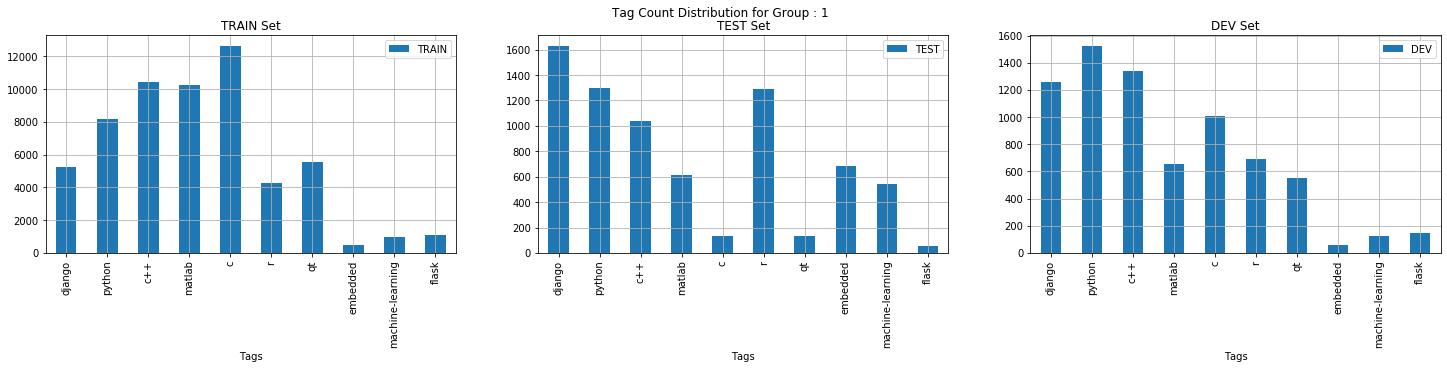

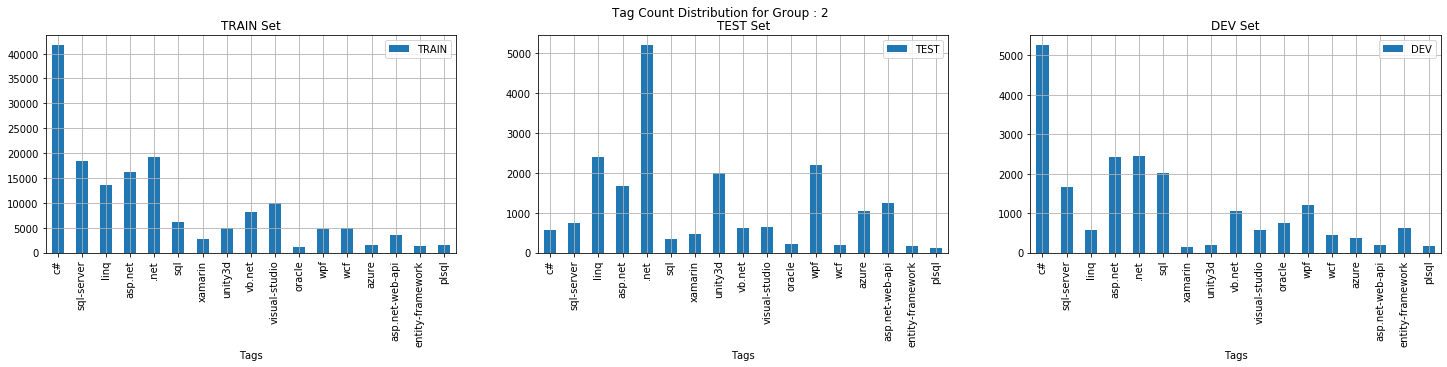

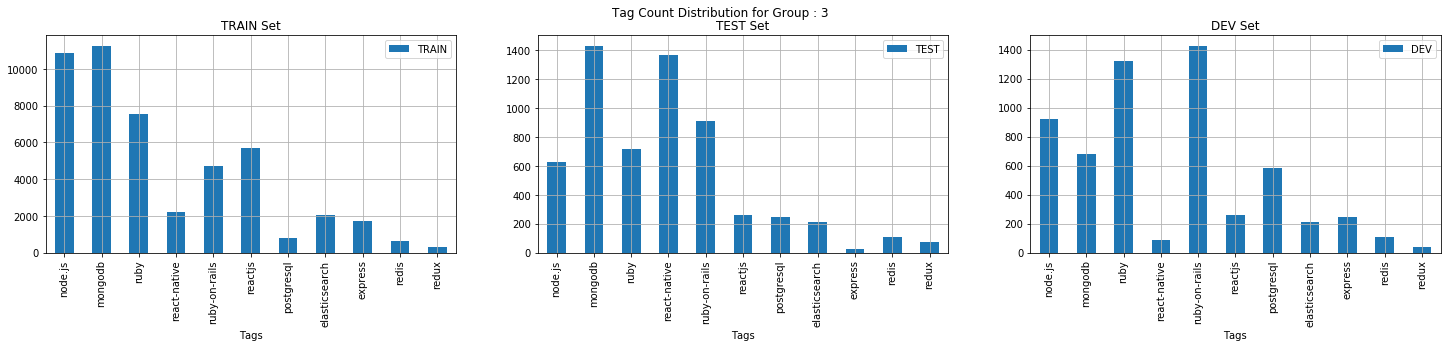

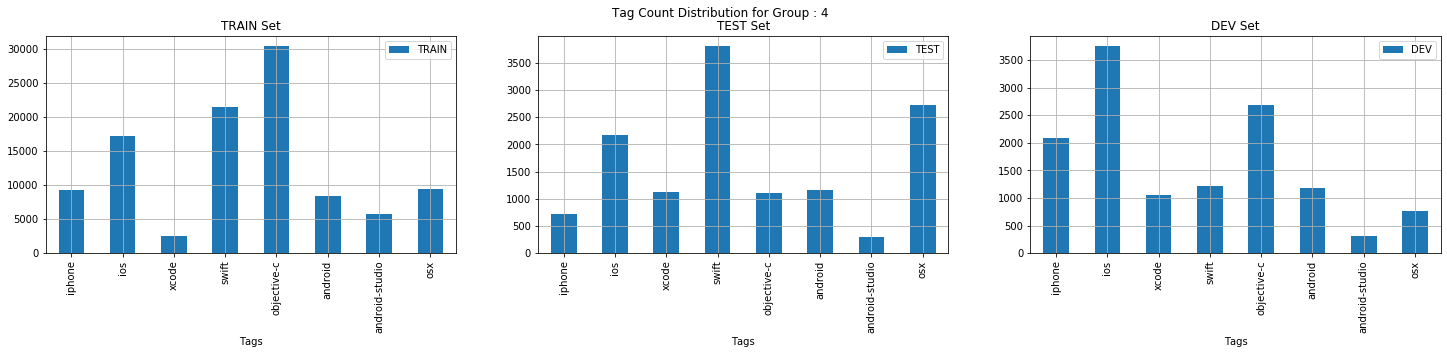

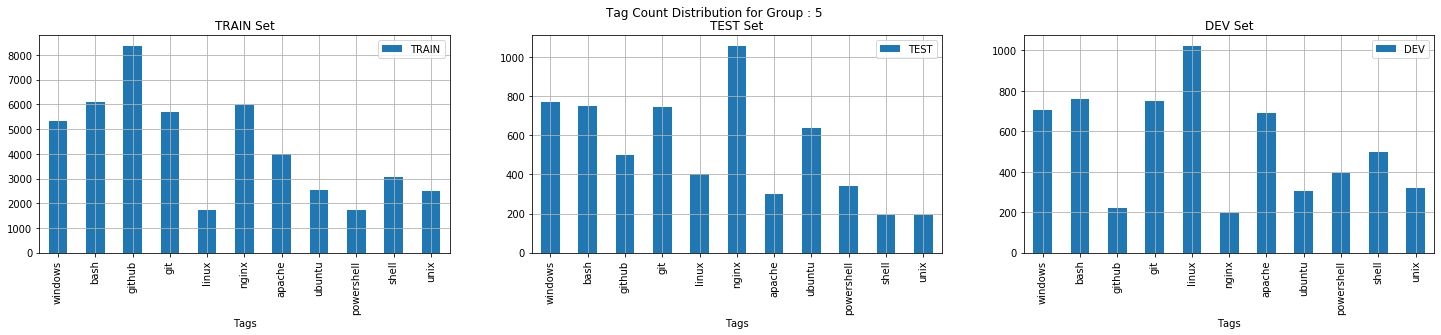

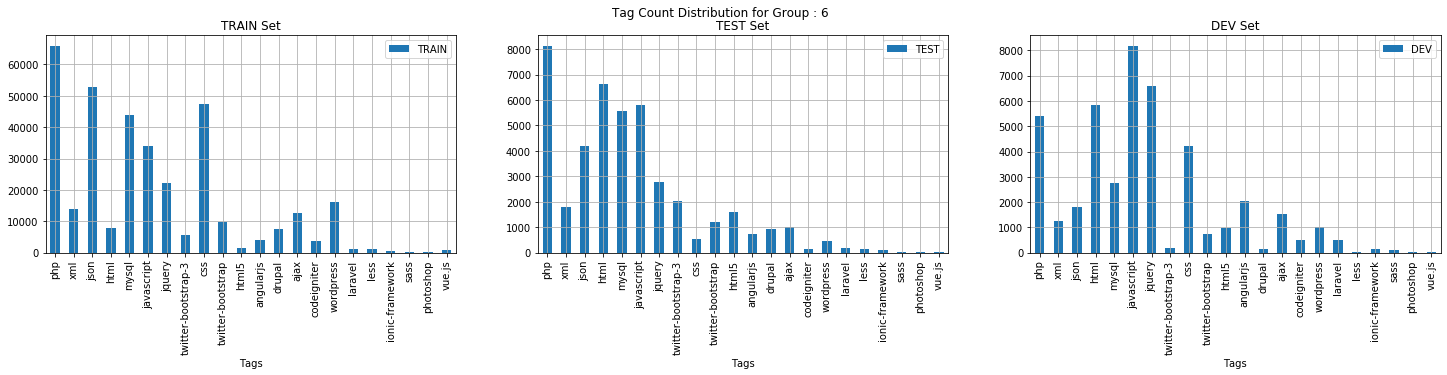

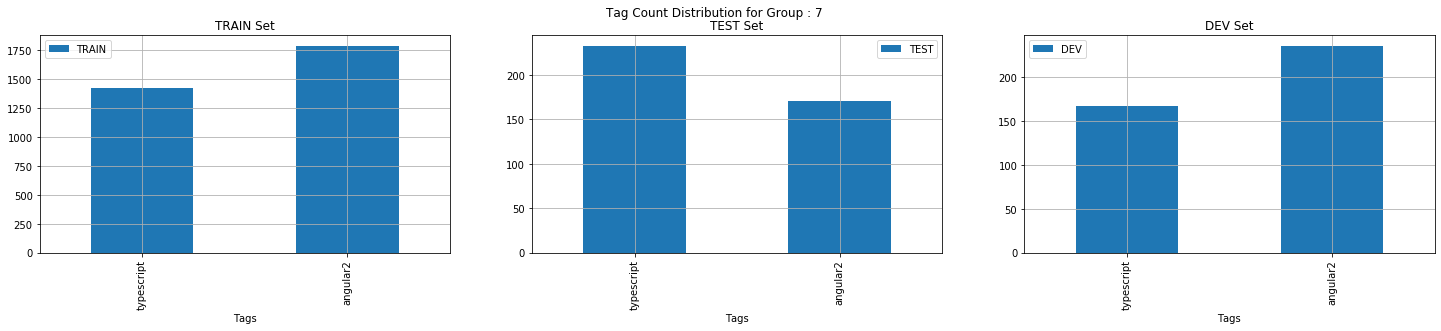

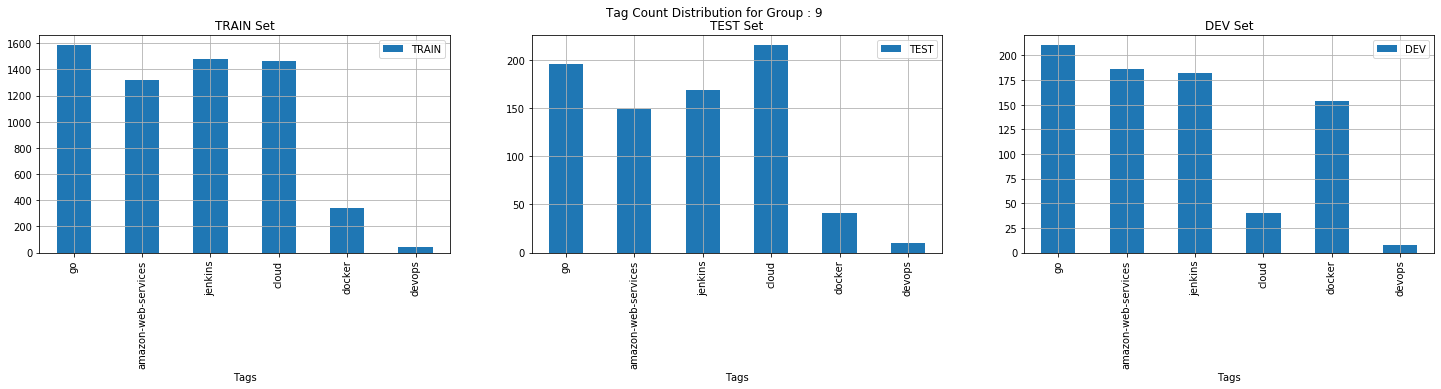

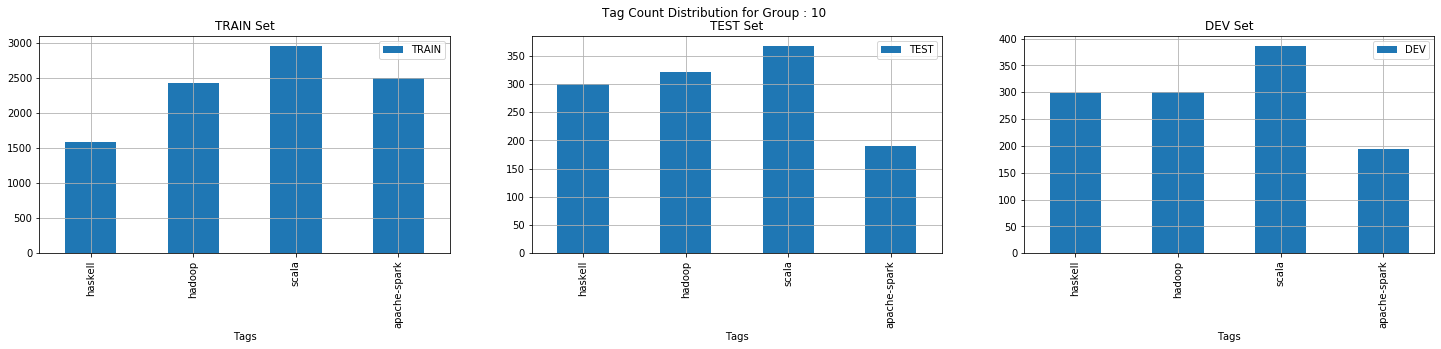

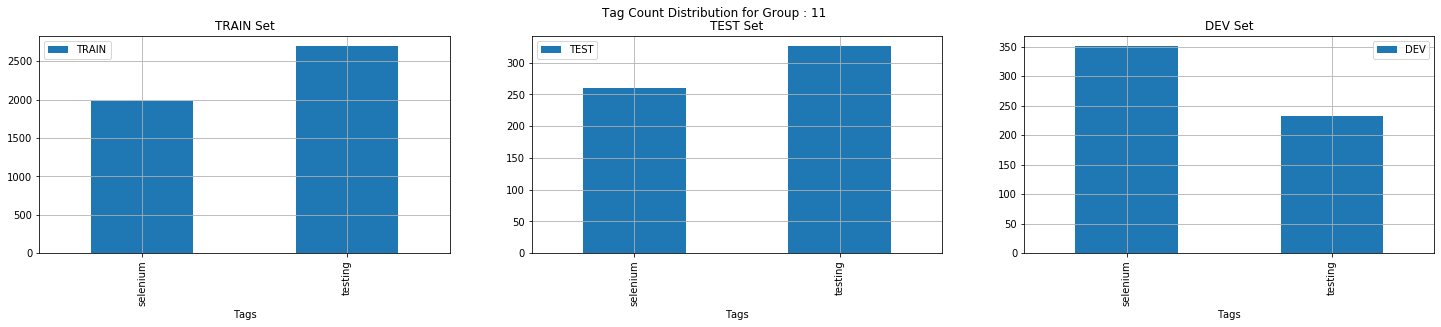

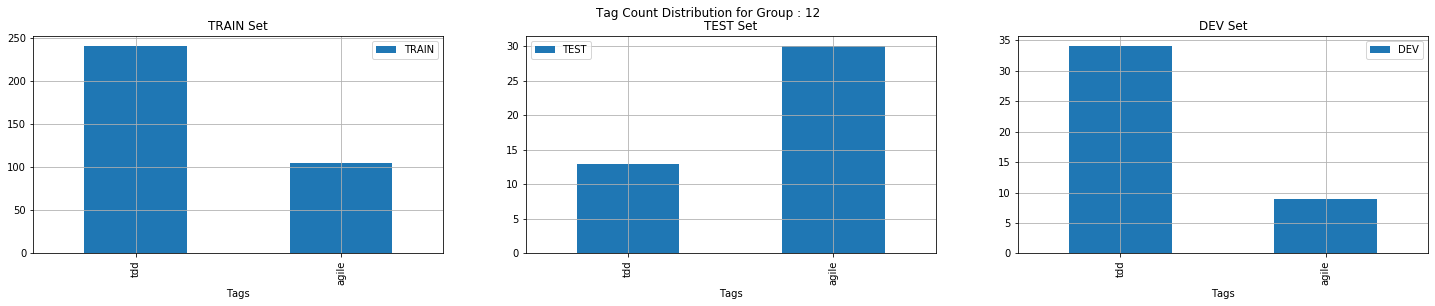

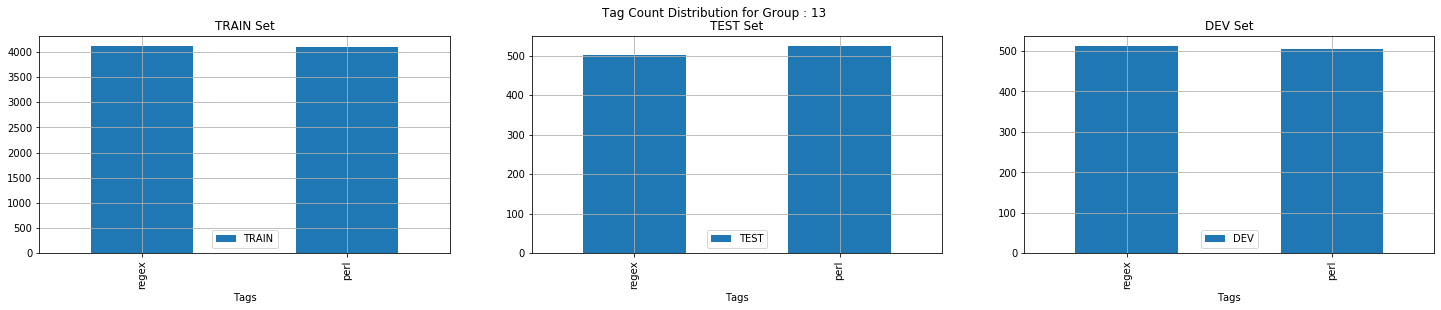

In [0]:
# Define Base path of data
base_path = 'training_data/normalised/group/'

# Iterate through the groups
for grp_id in range(1,15) :
  # Corpus Statistics JSON as the distributiuon
  file_path = path + base_path + str(grp_id) + '/corpus_statistics.json'
  
  with open(file_path,'r') as f :
    data = json.load(f)

  # Create Dataframe for the Group
  df = pd.DataFrame(columns =['Tags','TRAIN','TEST','DEV'])

  # Iterate Train/Dev/Test
  for key in ['TRAIN','TEST','DEV']:
    tags = data[key]['number_of_documents_per_class']
    docs =  data[key]['total_number_of_documents']

    tag_list = []
    tag_count = []

    for tag in tags :
      tag_list.append(tag)
      tag_count.append(tags[tag])  

    df[key] = tag_count
  df['Tags'] = tag_list


  # Divide the Figure to 3 sub-plot
  fig, ((ax1, ax2,ax3)) = plt.subplots(1,3,figsize=(25,4))

  plot_title = 'Tag Count Distribution for Group : {}'.format(grp_id)
  fig.suptitle(plot_title)

  # PLot the graphs
  
  df.plot(kind='bar',x='Tags',y='TRAIN',grid=True,ax=ax1,title= 'TRAIN Set')
  df.plot(kind='bar',x='Tags',y='TEST',grid=True,ax=ax2,title= 'TEST Set')
  df.plot(kind='bar',x='Tags',y='DEV',grid=True,ax=ax3,title= 'DEV Set')
# df.head()